In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml

# Load CIFAR-10 dataset from OpenML
cifar10 = fetch_openml('CIFAR_10', version=1)

# The dataset from OpenML provides data in a structured format
x = cifar10.data.to_numpy()
y = cifar10.target.to_numpy().astype(int)

# Filter out only "Cat" (class 3) and "Dog" (class 5)
cat_dog_idx = np.isin(y, [3, 5])
x_cat_dog = x[cat_dog_idx]
y_cat_dog = np.where(y[cat_dog_idx] == 3, 1, -1)  # Map Cat = 1, Dog = -1

# Confirm the shape after filtering
print(f"Shape of data after filtering: {x_cat_dog.shape}")
print(f"Shape of labels after filtering: {y_cat_dog.shape}")


Shape of data after filtering: (12000, 3072)
Shape of labels after filtering: (12000,)


In [2]:
# Normalize the data (PCA works better with normalized data)
x_cat_dog = x_cat_dog.astype(np.float32) / 255.0

# Flatten images from (32, 32, 3) to (3072,)
x_cat_dog_flat = x_cat_dog.reshape(x_cat_dog.shape[0], -1)

# Split data into training and test sets (80% training, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x_cat_dog_flat, y_cat_dog, test_size=0.2, random_state=42)

# Check the shape of the split data
print(f"Shape of X_train: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"Shape of X_test: {x_test.shape}, y_test shape: {y_test.shape}")


Shape of X_train: (9600, 3072), y_train shape: (9600,)
Shape of X_test: (2400, 3072), y_test shape: (2400,)


In [3]:
# Apply PCA to reduce dimensionality 
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Check the shape after PCA transformation
print(f"Shape of X_train_pca: {x_train_pca.shape}")
print(f"Shape of X_test_pca: {x_test_pca.shape}")


Shape of X_train_pca: (9600, 100)
Shape of X_test_pca: (2400, 100)


In [4]:
# Define MLPClassifier model
mlp = MLPClassifier(max_iter=200, hidden_layer_sizes=(512, 128, 64), alpha = 0.001,random_state=42)
# Train the model on the training data
mlp.fit(x_train_pca, y_train)

# Evaluate on training data
train_acc = accuracy_score(y_train, mlp.predict(x_train_pca))
print(f"Training Accuracy: {train_acc:.4f}")

Training Accuracy: 1.0000


In [5]:
from sklearn.model_selection import RandomizedSearchCV

# Define MLPClassifier model
mlp = MLPClassifier(max_iter=200, hidden_layer_sizes=(512, 128, 64), alpha = 0.001,random_state=42)

# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    "hidden_layer_sizes": [(512, 256, 128), (1024, 512, 256), (256, 128, 64)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.001, 0.01, 0.1, 1],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    mlp, param_distributions=param_dist, n_iter=20, cv=3, scoring="accuracy", n_jobs=-1, random_state=42, verbose=2
)

# Fit the RandomizedSearchCV model to the training data
random_search.fit(x_train_pca, y_train)

# Best model from RandomizedSearchCV
best_mlp = random_search.best_estimator_

# Print best parameters
print(f"Best Parameters from RandomizedSearchCV: {random_search.best_params_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/astiwar1/.conda/envs/statml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/astiwar1/.conda/envs/statml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Parameters from RandomizedSearchCV: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (512, 256, 128), 'alpha': 0.001, 'activation': 'relu'}


In [6]:
# Make predictions on the test set
y_pred = best_mlp.predict(x_test_pca)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.65875
Classification Report:
               precision    recall  f1-score   support

          -1       0.66      0.64      0.65      1196
           1       0.66      0.67      0.66      1204

    accuracy                           0.66      2400
   macro avg       0.66      0.66      0.66      2400
weighted avg       0.66      0.66      0.66      2400



Test AUROC: 0.6586975966399626


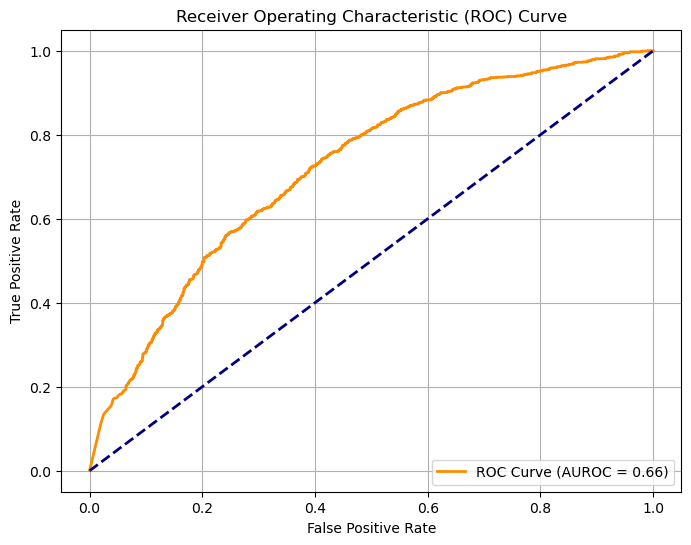

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate AUROC
auroc = roc_auc_score(y_test, y_pred)
print(f"Test AUROC: {auroc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, best_mlp.predict_proba(x_test_pca)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUROC = {auroc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [8]:
# Calculate per-class accuracy
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Per-Class Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i + 1}: {acc:.2f}")


Per-Class Accuracy:
Class 1: 0.64
Class 2: 0.67


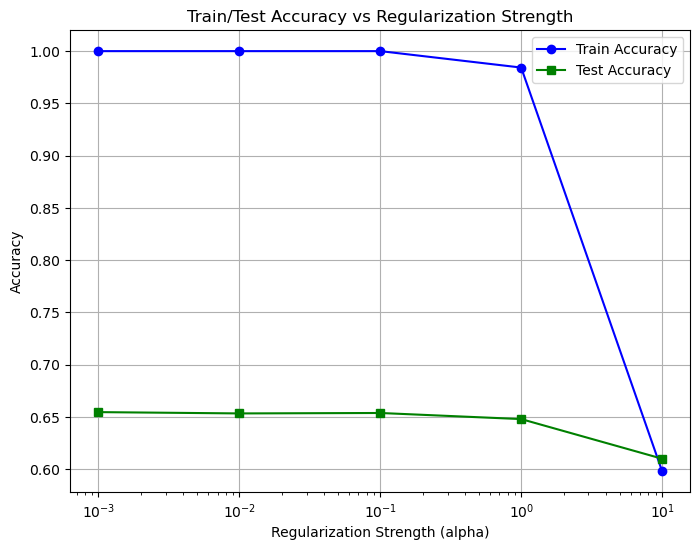

In [9]:
alphas = [0.001, 0.01, 0.1, 1, 10]
train_accuracies = []
test_accuracies = []

for alpha in alphas:
    model = MLPClassifier(max_iter=600, hidden_layer_sizes=(1024, 512), alpha=alpha, random_state=42)
    model.fit(x_train_pca, y_train)
    train_accuracies.append(model.score(x_train_pca, y_train))
    test_accuracies.append(model.score(x_test_pca, y_test))

# Plot accuracy as a function of alpha
plt.figure(figsize=(8, 6))
plt.plot(alphas, train_accuracies, marker='o', label="Train Accuracy", color="blue")
plt.plot(alphas, test_accuracies, marker='s', label="Test Accuracy", color="green")
plt.xscale("log")
plt.xlabel("Regularization Strength (alpha)")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy vs Regularization Strength")
plt.legend()
plt.grid(True)
plt.show()


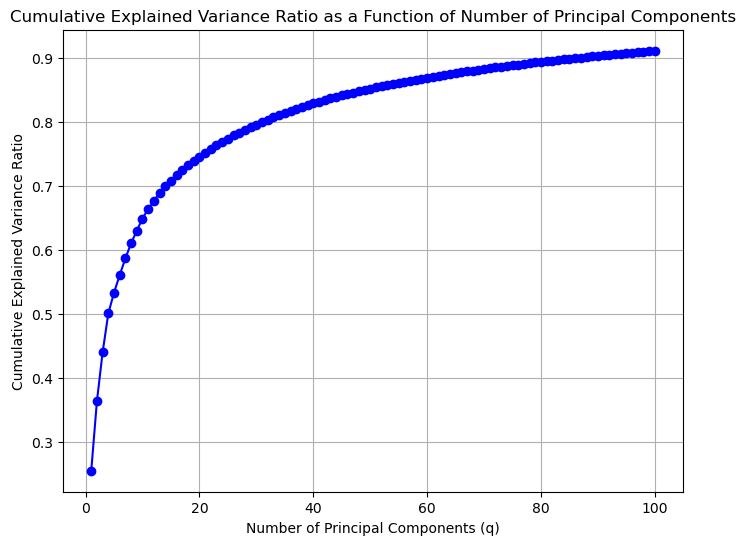

In [10]:
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.title("Cumulative Explained Variance Ratio as a Function of Number of Principal Components")
plt.xlabel("Number of Principal Components (q)")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)
plt.show()


/home/astiwar1/.conda/envs/statml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/astiwar1/.conda/envs/statml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/astiwar1/.conda/envs/statml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/astiwar1/.conda/envs/statml/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(


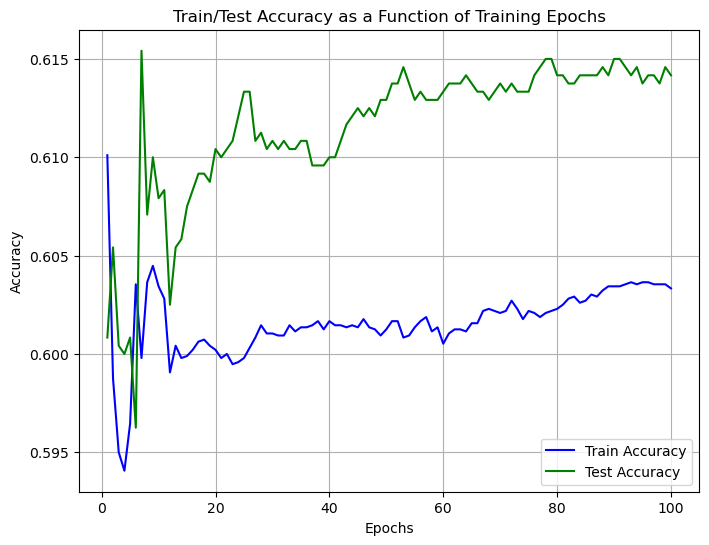

[CV] END activation=relu, alpha=1, hidden_layer_sizes=(256, 128, 64), learning_rate_init=0.1, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(1024, 512, 256), learning_rate_init=0.01, solver=adam; total time=  30.8s
[CV] END activation=relu, alpha=1, hidden_layer_sizes=(1024, 512, 256), learning_rate_init=0.001, solver=adam; total time=  30.8s
[CV] END activation=relu, alpha=1, hidden_layer_sizes=(1024, 512, 256), learning_rate_init=0.01, solver=adam; total time=  41.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(1024, 512, 256), learning_rate_init=0.001, solver=adam; total time=  34.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(1024, 512, 256), learning_rate_init=0.001, solver=adam; total time= 1.2min
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.001, solver=adam; total time=  27.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(1024, 512, 256), learning_r

In [11]:
# Train/Test Accuracy as a function of epochs
mlp_epochs = MLPClassifier(
    max_iter=1, 
    hidden_layer_sizes=(1024, 512), 
    alpha=10, 
    random_state=42, 
    warm_start=True
)

train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(1, 101):  # Train for 100 epochs
    mlp_epochs.max_iter = epoch
    mlp_epochs.fit(x_train_pca, y_train)
    train_accuracy_epochs.append(mlp_epochs.score(x_train_pca, y_train))
    test_accuracy_epochs.append(mlp_epochs.score(x_test_pca, y_test))

# Plot accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_accuracy_epochs, label="Train Accuracy", color="blue")
plt.plot(range(1, 101), test_accuracy_epochs, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy as a Function of Training Epochs")
plt.legend()
plt.grid(True)
plt.show()
